# Homework 2 - Linear Regression

### Dataset

Car Fuel Efficiency dataset:
```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
```
The goal of this homework is to create a regression model for predicting the car fuel efficiency (column `'fuel_efficiency_mpg'`).

### Preparing the dataset 

Use only the following columns:

* `'engine_displacement'`,
* `'horsepower'`,
* `'vehicle_weight'`,
* `'model_year'`,
* `'fuel_efficiency_mpg'`

### EDA

* Look at the `fuel_efficiency_mpg` variable. Does it have a long tail?


In [3]:
import pandas as pd
import numpy as np

#in case we need to download the data
# data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
# !wget $data 

df = pd.read_csv('../data/car_fuel_efficiency.csv')

# Data cleaning
df = df.copy()
df = df[['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']]







<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

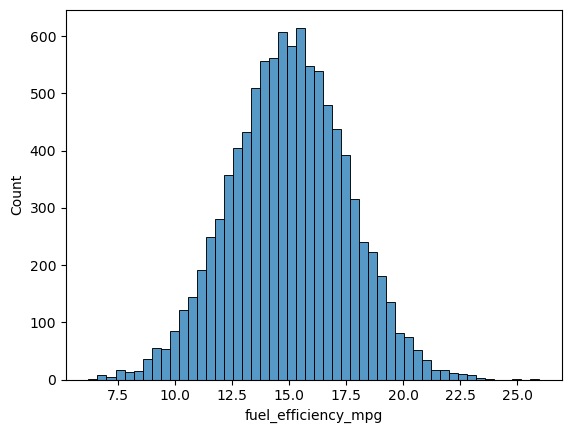

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.histplot(df['fuel_efficiency_mpg'], bins=50)


### Question 1

There's one column with missing values. What is it?

* `'engine_displacement'`
* `'horsepower'`   <---
* `'vehicle_weight'`
* `'model_year'`


In [5]:
df.isnull().sum()

#horsepower has 708 missing columns

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64



### Question 2

What's the median (50% percentile) for variable `'horsepower'`?

- 49
- 99
- 149 <---
- 199


In [6]:
df.horsepower.describe()

#149 

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64


### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures



In [7]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)


df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

len(y_train)



5824

In [8]:
df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year
0,220,144.0,2535.887591,2009
1,160,141.0,2741.170484,2019
2,230,155.0,2471.880237,2017
3,150,206.0,3748.164469,2015
4,300,111.0,2135.716359,2006



### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean <---
- Both are equally good


In [9]:
#option 1: df_train.fillna(0)
#option 2: df_train.fillna(df_train.horsepower.mean())

#code from the lesson:
# Linear regression
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

# RMSE
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Training Data prep
#option1 - fill with 0
def prepare_X0(df):
    df = df.fillna(0)
    X = df.values
    return X
#option2 - fill with mean
def prepare_Xm(df):
    df = df.fillna(df.horsepower.mean())
    X = df.values
    return X

In [ ]:
# Training 1 - fill with 0
X_train0 = prepare_X0(df_train)
w0_0, w_0 = train_linear_regression(X_train0, y_train)

print(w0_0, w_0)

# Training 2 - fill with mean
X_trainm = prepare_Xm(df_train)
w0_m, w_m = train_linear_regression(X_trainm, y_train) 

print(w0_m, w_m)

# Validation 1 - fill with 0
X_val0 = prepare_X0(df_val)
y_pred0 = w0_0 + X_val0.dot(w_0)
rmse0 = rmse(y_val, y_pred0)
print(rmse0)    


# Validation 2 - fill with mean
X_valm = prepare_Xm(df_val)
y_predm = w0_m + X_valm.dot(w_m)
rmsem = rmse(y_val, y_predm)
print(rmsem)

print('RMSE fill 0:', round(rmse0, 2))
print('RMSE fill mean:', round(rmsem, 2))

#mean is better

28.827365476143953 [ 9.93613218e-05  3.54221891e-03 -5.01328015e-03  3.42992868e-04]
28.925259953168613 [ 0.00012093  0.01030308 -0.00501009 -0.00023463]
0.5173782638854008
0.4636236995029561
RMSE fill 0: 0.52
RMSE fill mean: 0.46




### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If multiple options give the same best RMSE, select the smallest `r`.

Options:

- 0
- 0.01 <---
- 1
- 10
- 100


In [ ]:
# linear regression with regularization code

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

# fill NA with 0
X_train0 = prepare_X0(df_train)

#parameters to try
params = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in params:
    w0_0, w_0 = train_linear_regression_reg(X_train0, y_train, r=r)
    X_val0 = prepare_X0(df_val)
    y_pred0 = w0_0 + X_val0.dot(w_0)
    rmse0 = rmse(y_val, y_pred0)
    print(r, rmse0, round(rmse0, 2))

#0.01 is best

0 0.5173782638854008 0.52
0.01 0.5171115525772979 0.52
0.1 0.5187525130700571 0.52
1 0.5222348802092388 0.52
5 0.5228916092823451 0.52
10 0.5229812979636552 0.52
100 0.5230636233819927 0.52




### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.001
- 0.006 <---
- 0.060
- 0.600

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.



In [ ]:
#seed list

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_results = []
for s in seeds:
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    X_train0 = prepare_X0(df_train)
    w0_0, w_0 = train_linear_regression(X_train0, y_train)

    #print(w0_0, w_0)

    X_val0 = prepare_X0(df_val)
    y_pred0 = w0_0 + X_val0.dot(w_0)
    rmse0 = rmse(y_val, y_pred0)
    print(s, rmse0, round(rmse0, 3))
    rmse_results.append(rmse0)

std_rmse = np.std(rmse_results)

print('Standard Deviation of RMSE:', std_rmse)

#0.007~ 

0 0.514295141161739 0.514
1 0.5091424577033027 0.509
2 0.5159337545109791 0.516
3 0.5042021939859033 0.504
4 0.528328936365831 0.528
5 0.5252936009505769 0.525
6 0.5194784145905931 0.519
7 0.5186432031401893 0.519
8 0.511148268458307 0.511
9 0.5120183067679349 0.512
Standard Deviation of RMSE: 0.006969562864228692



### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.15
- 0.515 <---
- 5.15
- 51.5


In [ ]:
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_combo = pd.concat([df_train, df_val])
y_combo = np.concatenate([y_train, y_val])

X_combo = prepare_X0(df_combo)
test_r = 0.01
w0_0, w_0 = train_linear_regression_reg(X_combo, y_combo, r=test_r)
print(w0_0, w_0)

X_test = prepare_X0(df_test)
y_pred = w0_0 + X_test.dot(w_0)
rmse0 = rmse(y_test, y_pred)
print(s, test_r, rmse0, round(rmse0, 3))

# rmse ~ 0.515

25.561729162503788 [ 3.41612831e-05  3.61938289e-03 -5.01514666e-03  1.97270817e-03]
9 0.01 0.5164533819985268 0.516
